从2.2开始每一小节均可单独完整运行（所需文件仓库均已提供）

# 数据预处理

将轨迹转化为unwarped类型

In [23]:
import os
import subprocess

In [21]:
def convtrj_unwraped(xtc_file):
    result_xtc = xtc_file[:-4] + '_unwarpped.xtc'
    cmd = "gmx trjconv -f " + xtc_file + ' -pbc nojump -o ' + result_xtc
    subprocess.call(cmd, shell=True)    

In [40]:
files_dirs = ['3.5nm/','4.4nm/','5.6nm/']
for directory in files_dirs:
    files = os.listdir(directory)
    npt_xtc = [directory+i for i in files if (i.endswith('.xtc') and 'unwarpped' not in i)]
    for xtc in  npt_xtc:
        convtrj_unwraped(xtc)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "It's more useful when you know what you're doing." (Artem Zhmurov)



Note that major changes are planned in future for trjconv, to improve usability and utility.


                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "I've Got Two Turntables and a Microphone" (B. Hansen)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tiele

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "Push It Real Good" (Salt 'n' Pepa)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincen

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "No great discovery was ever made without a bold guess." (Marie Curie)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "I think it would be a good idea." (Mahatma Gandhi, when asked what he thought of Western civilization)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Al

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "I Am the Psychotherapist. Please, Describe Your Problems." (GNU Emacs)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijber

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "I Smell Smoke From a Gun Named Extinction" (Pixies)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tielema

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "Developing the AI requires the work of a data scientist, and most of them understand neither data nor science." (Scott LeGrand)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz 

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "The future always gets twisted and turned" (Lisa o Piu)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tie

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "You Try to Run the Universe" (Tricky)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vin

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "Chance favors the prepared mind." (Louis Pasteur)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman 

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "Or (horrors!) use Berendsen!" (Justin Lemkul)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman     

Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000    ->  frame  50000 time 200000.000      


GROMACS reminds you: "Install our Free Energy Patents app! There is energy all around us; and it's free! Free energy is everywhere, and all around you, just waiting to be extracted! Over 100+ free energy patents!" (Mind and Miracle Productions on Twitter, spamming a FEP thread)

                     :-) GROMACS - gmx trjconv, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     E

Note that major changes are planned in future for trjconv, to improve usability and utility.


Note that major changes are planned in future for trjconv, to improve usability and utility.


Last frame      50000 time 200000.000   


GROMACS reminds you: "Research ! A mere excuse for idleness; it has never achieved, and will never achieve any results of the slightest value." (Benjamin Jowett, British theologian, 1817-93)



# 计算并保存电导率数据

## 计算MSD

In [18]:
import os
import numpy as np
import MDAnalysis as mda
import MDAnalysis.analysis.msd as msd

In [25]:
def MSD(tpr_file,xtc_file,atom_select,begin = 0,end = -1):
        
    u = mda.Universe(tpr_file,xtc_file)
    MSD = msd.EinsteinMSD(u, select=atom_select, msd_type='xyz', fft=True)
    MSD.run(start=begin,stop=end)
    msd_result =  MSD.results.timeseries
    
    return msd_result

In [30]:
files_dirs = ['3.5nm/','4.4nm/','5.6nm/']
for directory in files_dirs:
    
    files = os.listdir(directory)
    if 'results' not in files:
        os.mkdir(directory+'results')
    
    npt_tpr = [i for i in files if '.tpr' in i][0]
    npt_xtc = [i for i in files if ( i.endswith('.xtc') and 'unwarpped' in i)]
    
    for xtc in  npt_xtc:
        for atom_name in ['name POT','name CLA']:
            MSD_result = MSD(directory+npt_tpr,directory+xtc,atom_name,25000,50000)
            np.save(directory+'results/'+xtc[0:-4]+atom_name[-3:]+'_MSD',MSD_result)

## 计算电导率

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import linregress

In [3]:
def electrical_conductivity(MSD,timestep = 0.004 ,charge = 1,temperature = 300):
    linear_model = linregress(np.arange(len(MSD))*timestep,MSD)
    slope = linear_model.slope
    error = linear_model.rvalue
    
    diffusion_coefficient = slope * 1/6
    FF_RT = (9.6485*10**4)**2/8.314/temperature# F Fareday's constant R gas constant T absolute temperature
    
    conductivity = (charge**2)*(diffusion_coefficient/100*10**(-9))*FF_RT*1000
    
    return conductivity

In [4]:
files_dirs = ['3.5nm/','4.4nm/','5.6nm/']
EC_all = []
for directory in files_dirs:
    EC = []
    files = os.listdir(directory+'results/')
    files.sort()
    
    for npy in  files:
        MSD = np.load(directory+'results/'+npy)
        Ec = electrical_conductivity(MSD)
        EC.append(Ec)
    EC_all.append(EC)

In [5]:
EC = pd.DataFrame(EC_all).T
EC.columns = ['3.5nm','4.4nm','5.6nm']
EC.to_csv('results.csv',index = False)

# 绘图和分析

## MSD

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def plot_ax():

    fig, ax = plt.subplots(constrained_layout=True, figsize=(12 / 2.54, 9 / 2.54))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 2200)
    ax.tick_params(width=1)
    
    ax.set_xlabel('$\mathrm{time\ (ns)}$')
    ax.set_ylabel('$\mathrm{MSD\ (nm)}^2$')
    ax.set_xticks(np.arange(0,101,20))
    ax.set_xticklabels(ax.get_xticks())
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    
    return ax

def plot_MSD(box):
    ax =  plot_ax()
    files = os.listdir(box+'results/')
    files.sort()
    for npy in files:
        data = np.load(box+'results/'+npy)/100
        ls = '-' if 'POT' in npy else '--'
        ax.plot(np.linspace(0,100,len(data)),data,ls = ls,c = color,lw =1)    
    ax.legend(['$\mathrm{Cl}^-$','$\mathrm{K}^+$'])
    
    return ax

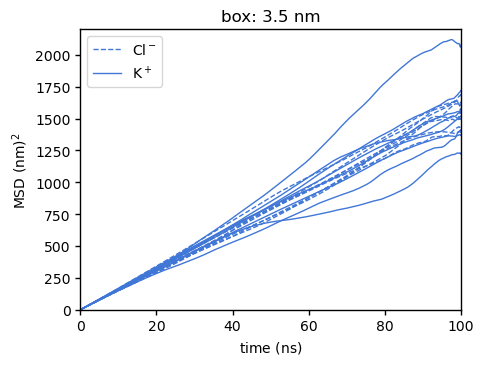

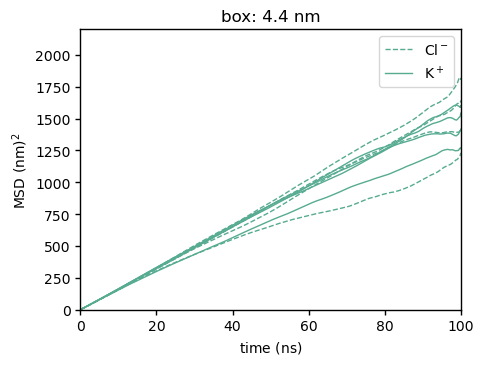

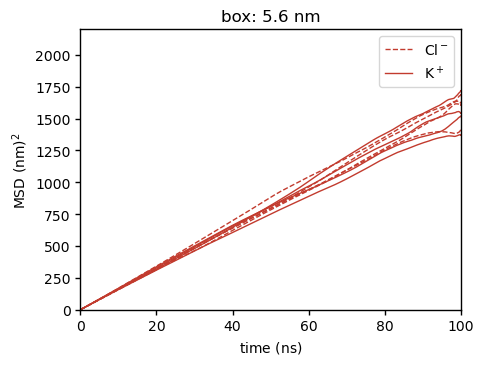

In [8]:
box = ['3.5','4.4','5.6']
colors = ['#4077d7','#56ab91','#c23b2e']
for i in box:
    color =colors[box.index(i)]
    ax = plot_MSD(i+'nm/')
    ax.set_title('box: '+i+' nm')
    plt.savefig('figures/'+i+'MSD.svg')

## 电导率

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
def plot_ax():

    fig, ax = plt.subplots(constrained_layout=True, figsize=(12 / 2.54, 9 / 2.54))
    ax.set_xlim(0,3)
    ax.set_ylim(0,25)
    ax.tick_params(width=1)
    
    ax.set_xlabel('$\mathrm{box\ size}$')
    ax.set_ylabel('$\mathrm{EC\ (S/m)}$')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['top'].set_linewidth(1)
    
    return ax

In [14]:
# 创建原始DataFrame
data = pd.read_csv('results.csv')
# 将两个相邻的行相加，并生成新的DataFrame
EC = data.groupby(data.index // 2).sum()

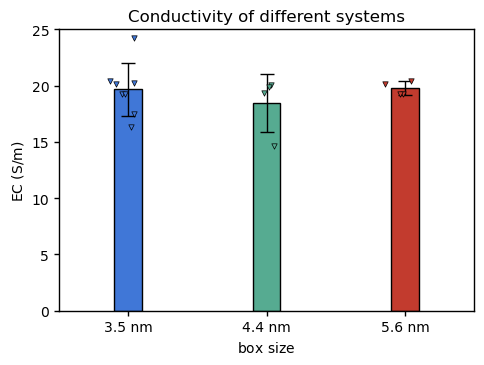

In [15]:
ax = plot_ax()
box = ['3.5nm','4.4nm','5.6nm']
colors = ['#4077d7','#56ab91','#c23b2e']
for i in range(len(box)):
    if i == 0:
        data = EC[box[i]]
    else:
        data = EC[box[i]][0:4]
    mean = data.mean()
    std  = data.std(ddof=1)
    error_params=dict(elinewidth=1,capthick = 1,capsize=5) 
    
    ax.bar([0.5+i],mean,yerr=std,error_kw=error_params,width = 0.2,color=colors[i],linewidth = 1,edgecolor='k')
    
    x = i+np.random.normal(0.5,0.05,len(data))
    ax.scatter(x,data,s = 15,marker='v',c = colors[i],edgecolors='k',linewidths = 0.5,zorder = 2)

ax.set_xticks([0.5,1.5,2.5], ['3.5 nm','4.4 nm','5.6 nm'])
ax.set_title('Conductivity of different systems')

plt.savefig('figures/conductivity.svg')

## 体系大小的影响

In [20]:
import pandas as pd
from scipy import stats

In [21]:
data = pd.read_csv('results.csv')
# 将两个相邻的行相加，并生成新的DataFrame
EC = data.groupby(data.index // 2).sum()

onetwo   = stats.ttest_ind(EC['3.5nm'],EC['4.4nm'][0:4],equal_var=False,trim=0)
onethree = stats.ttest_ind(EC['3.5nm'],EC['5.6nm'][0:4],equal_var=False,trim=0)
twothree = stats.ttest_ind(EC['4.4nm'][0:4],EC['5.6nm'][0:4],equal_var=False,trim=0)

print(onetwo,'\n',onethree,'\n',twothree)

Ttest_indResult(statistic=0.7956750145110496, pvalue=0.4587093165965584) 
 Ttest_indResult(statistic=-0.0960472936070558, pvalue=0.9256513491366649) 
 Ttest_indResult(statistic=-0.9831616216985831, pvalue=0.39102623920436014)
